### Data Science Challenge - José Matheus
That was very hard for me to do. I don't know much about Data Science other than it is very heavy in statistic, which makes sense for what it achieves. But it did not took long to figure out that this is a challenge related to Time Series, although it may be possible with ANNs as was suggest on the description. The hard part was trying to understand the model, ARIMA, that is used for this task. I probably made some big mistakes, but most of what is here is knew to me.

#### Intro
There are many ways that I can predict here, but the most important values are entries, exists, and each time. I tried to analyses overall (instead of one selected station) entries through months of each year. And like I said before I will use the ARIMA model.
I played a bit with the data before getting to what a will show here. The following is just a step by step of the most important part of it.

In [1]:
# Importing some essential packages, plus ZipFile and GzipFile to read the data
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime

from zipfile import ZipFile
from gzip import GzipFile

plt.rcParams['figure.figsize'] = 15, 6

In [2]:
# Load all the data.
# Like I said on the intro, I'm just looking for overall entries over time,
# so I'm only selecting those columns in order to save memory
df = []
zip_file = ZipFile('dados_desafio.zip')
# print(zip_file.namelist())
df = []
for file in zip_file.namelist():
    print(file)
    # Appending dat on a list
    df.append((pd.read_csv(GzipFile(fileobj=zip_file.open(file)))).filter(['time', 'entries'], axis=1))

# Concatenating the list into a DataFrame
df = pd.concat(df)
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)

2010.csv.gz
2011.csv.gz
2012.csv.gz
2013.csv.gz
2014.csv.gz
2015.csv.gz
2016.csv.gz
2017.csv.gz


In [3]:
# I can't use 'time' as index since it reapeats several times
# The first month starts on the 17th
# That can be a problem if I wanna look through the entries in a month
df.head(5)

,time,entries
0,2010-04-17 04:00:00,2704717.0
1,2010-04-17 04:00:00,2697632.0
2,2010-04-17 04:00:00,1127722.0
3,2010-04-17 04:00:00,2425570.0
4,2010-04-17 04:00:00,2214633.0


In [4]:
# The last month is not only incomplete but also have an incomplete day
df.tail(5)

,time,entries
7466020,2017-09-23 03:56:54,287490.0
7466021,2017-09-23 03:57:36,180472.0
7466022,2017-09-23 03:57:58,55333.0
7466023,2017-09-23 03:58:51,1497618.0
7466024,2017-09-23 03:59:46,822848.0


In [5]:
# In here we can see twos months with some days with 0 entries
(df.groupby(df.time).agg({"entries": sum})).resample("d").sum().query('entries == 0')

# Those prints give an idea of things I should drop out of the data in order to better predict

,entries
time,
2010-04-25,0.0
2010-04-26,0.0
2010-04-27,0.0
2010-04-28,0.0
2010-04-29,0.0
2010-04-30,0.0
2010-05-16,0.0
2010-05-17,0.0
2010-05-18,0.0


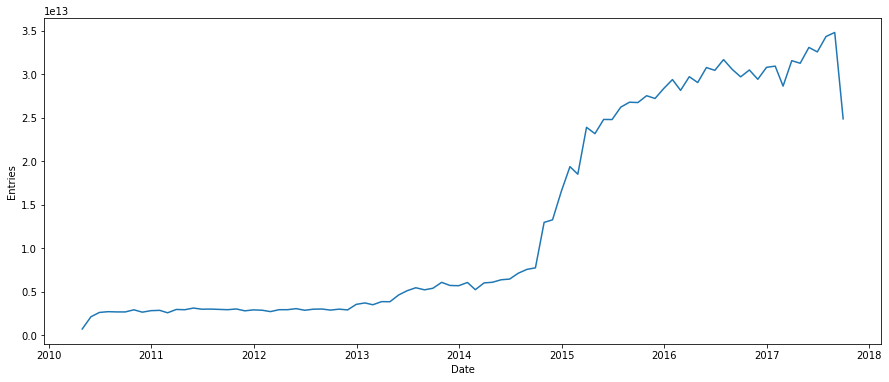

In [6]:
# Plotting all the data
plt.xlabel("Date")
plt.ylabel("Entries")

# I'm grouping by time and accumulating all the entries of given time
new_df = df.groupby(df.time).agg({"entries": sum})
# Now I resample the 'time' to accumulate each month of the year
new_df = new_df.resample("M").sum()
# Plotting the graph
plt.plot(new_df)
# I can see great variance in the tail and the head, caused by the incomplete months

In [7]:
# With this new DataFrame, now 'time' is the index
new_df.index[:10]

DatetimeIndex(['2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31',
               '2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30',
               '2010-12-31', '2011-01-31'],
              dtype='datetime64[ns]', name='time', freq='M')

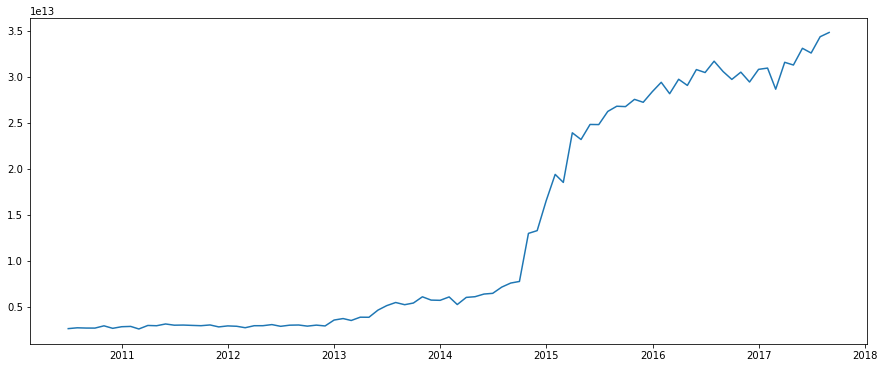

In [8]:
# Chopping the tail and the head and plotting
plt.plot(new_df.iloc[2:-1])
# Now looks fine

In [9]:
# Making the changes in the variable
new_df = new_df.iloc[2:-1]

In [10]:
# Separating train and test groups
train_df = new_df[:70]
test_df = new_df[70:]
print(new_df.shape)
print(train_df.shape, test_df.shape)

(87, 1)
(70, 1) (17, 1)


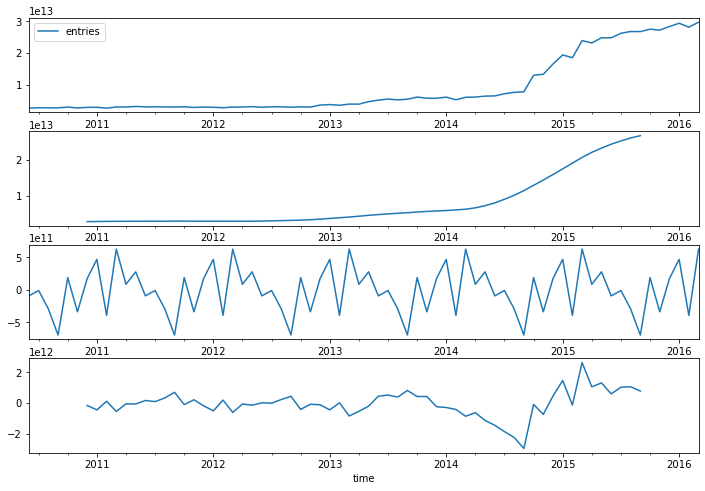

In [11]:
# In here I make a function to decompose and plot the input data in trend, seasonal and residual behaviours
# Importing 'seasonal_decompose' to achieve this
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_this(idf):

    decomposed = seasonal_decompose(idf)

    fig , a = plt.subplots(4,1, figsize=(12,8))
    idf.plot(ax=a[0])
    decomposed.trend.plot(ax=a[1])
    decomposed.seasonal.plot(ax=a[2])
    decomposed.resid.plot(ax=a[3])

# In here I decompose the training data
decompose_this(train_df)
# The data doesn't look stationary at all (we could see that in the previous plot already)

In [12]:
# Simple function that makes and prints the Dickey-Fuller test results
# Importing 'adfuller' to achieve this
from statsmodels.tsa.stattools import adfuller

def dftest(idf):
    idf = idf.dropna()
    to_test = adfuller(idf["entries"], autolag='AIC')
    result = pd.Series(to_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key,value in to_test[4].items():
        result['Critical Value (%s)' %key] = value
    
    print(result)

# Dickey-Fuller test in training data
dftest(train_df)
# The most important value in here is 'p-value', 
# which should be below 0.05 in order to be considered stationary series, the lower the better
# So we can conclude that indeed is not a stationay series, as expected from the previus plots

Test Statistic                  0.759554
p-value                         0.990954
#Lags Used                     11.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


Test Statistic                 -1.859166
p-value                         0.351508
#Lags Used                     10.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


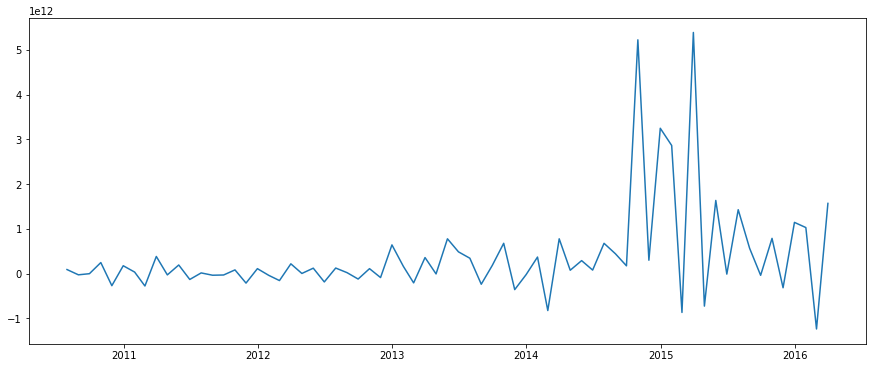

In [13]:
# We can make use differencing in order to make this series stationary
diff_train_df = train_df.diff().dropna()
# A much better p-value is achieved but still far from expected
dftest(diff_train_df)
plt.plot(diff_train_df)

Test Statistic                 -3.635934
p-value                         0.005110
#Lags Used                     11.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


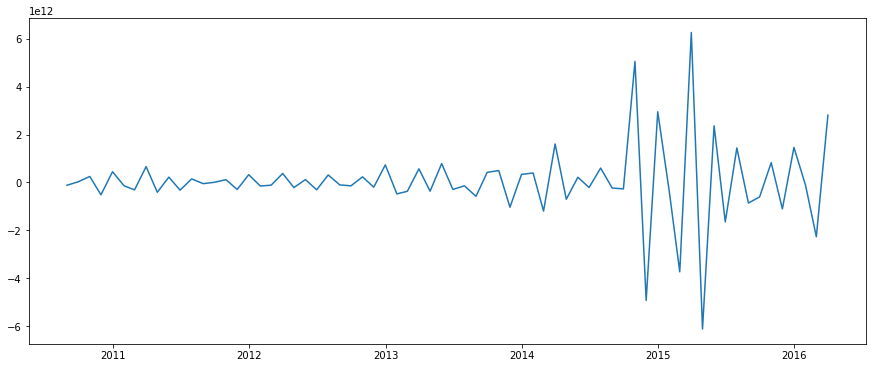

In [14]:
# Trying differencing over the previeus differencing 
diff2_train_df = diff_train_df.diff().dropna()
# A much better result is now achieved
dftest(diff2_train_df)
plt.plot(diff2_train_df)

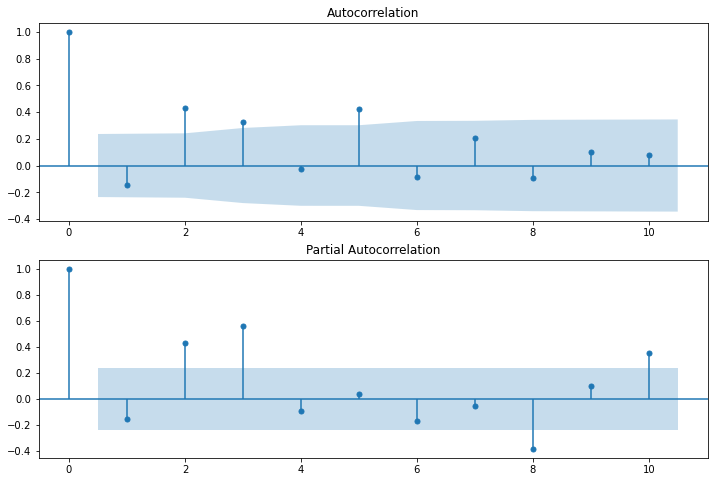

In [15]:
# Now we start entering ARIMA
# ARIMA needs 3 parameters 'p', 'd' and 'q', the last step was made to get 'd'
# With two differencing steps our d = 2
# Now we need 'p' and 'q'

# We can get 'p' and 'q' by plotting acf and pacf over the first differencing of the training data
import statsmodels.api as sm


fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_train_df, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_train_df, lags=10, ax=ax2)
# With those two plots we can visualize what 'lag' was the first to enter the confidence interval
# Which was 1 for ACF, that makes q = 1, and also 1 for PACF, that makes p = 1
# So we have (p,d,q) <=> (1,2,1)



In [16]:
# With the parameters we can create and fit the model
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(train_df, order=(1,2,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                entries   No. Observations:                   70
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1973.308
Date:                Wed, 24 Nov 2021   AIC                           3952.616
Time:                        20:21:34   BIC                           3959.275
Sample:                    06-30-2010   HQIC                          3955.254
                         - 03-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5850      0.093     -6.307      0.000      -0.767      -0.403
ma.L1         -0.5519      0.106     -5.217      0.000      -0.759      -0.345
sigma2      1.061e+24   2.67e-26   3.98e+49      0.000    1.06e+24    1.06e+24
===================================================================================
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):               249.56
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):              10.95   Skew:                             1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+65. Standard errors may be unstable.
"""

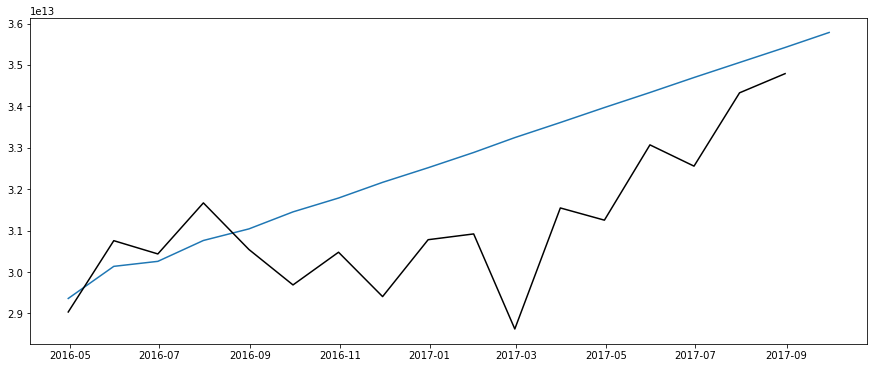

In [17]:
# After fitting, let's see how it performs in predicting the test
pred = model.predict(start=len(train_df),end=len(new_df))
plt.plot(pred)
plt.plot(test_df, color = 'black')
# It didn't perform that well, the predict continues to follow the previus upward trend

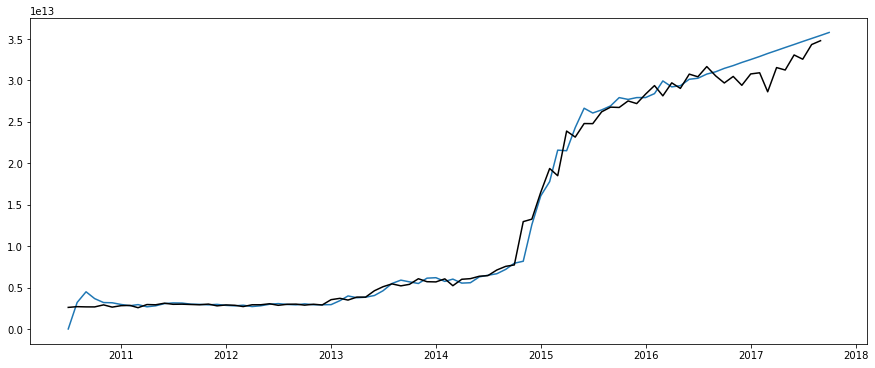

In [18]:
# Visualising how the predict compares to the complete data
pred = model.predict(start=0,end=len(new_df))
plt.plot(pred)
plt.plot(new_df, color = 'black')

That was it. It didn't perform that well. I couldn't find out what I was doing wrong, or maybe there is a better model for this kind of prediction. Althoug it look simple, this task really took me a lot of time to achieved the displayed results.